In [1]:
!pip install transformers datasets torch pandas

1. Initializing Extractive QA Foundation Model...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

RobertaForQuestionAnswering LOAD REPORT from: deepset/roberta-base-squad2
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



2. Loading Clinical Test Suite (Simulated Cohort)...

3. Executing Batch Transcriptomic Abstraction with Safety Thresholds...

--- BATCH EXTRACTION RESULTS ---
               Patient    Biomarker                      Extracted_Value
           Patient_001 PD-L1 Status                              65% tps
           Patient_001   ALK Fusion ⚠️ INCONCLUSIVE - MANUAL REVIEW REQ.
           Patient_001  HER2 Levels                               Normal
           Patient_002 PD-L1 Status                       Overexpression
           Patient_002   ALK Fusion                             Negative
           Patient_002  HER2 Levels            Significant amplification
Patient_003_INCOMPLETE PD-L1 Status ⚠️ INCONCLUSIVE - MANUAL REVIEW REQ.
Patient_003_INCOMPLETE   ALK Fusion                              Pending
Patient_003_INCOMPLETE  HER2 Levels ⚠️ INCONCLUSIVE - MANUAL REVIEW REQ.

4. Generating Confidence Analytics Graph...


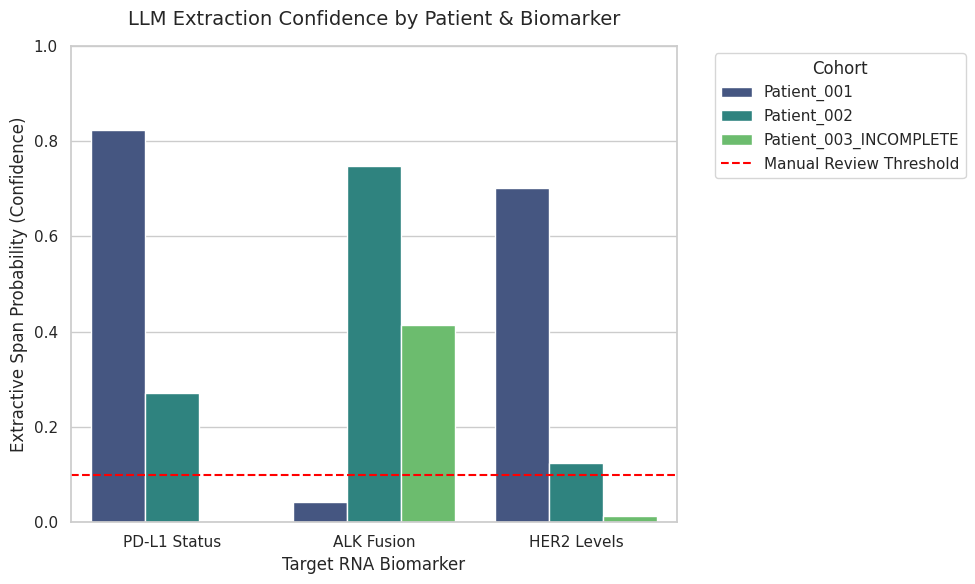

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
import warnings

# Suppress Hugging Face warnings to keep the notebook output clean
warnings.filterwarnings('ignore')

print("1. Initializing Extractive QA Foundation Model...")
# Using a robust RoBERTa model fine-tuned on SQuAD2.0 (handles unanswerable questions better)
biomarker_llm = pipeline("question-answering", model="deepset/roberta-base-squad2")

print("\n2. Loading Clinical Test Suite (Simulated Cohort)...")
# A human researcher tests multiple scenarios, not just the "happy path"
cohort_reports = {
    "Patient_001": """
        Molecular Profiling: Advanced NSCLC.
        Profound mRNA overexpression of CD274 (PD-L1) at 65% TPS.
        Analysis reveals a highly pathogenic EML4-ALK gene fusion.
        HER2 transcript levels are normal.
    """,
    "Patient_002": """
        Transcriptomic Report: Breast Carcinoma.
        No evidence of PD-L1 mRNA overexpression.
        Significant amplification of ERBB2 (HER2) transcripts detected.
        ALK fusions are negative.
    """,
    "Patient_003_INCOMPLETE": """
        Preliminary Biopsy Results:
        Sample degraded. RNA quality (RIN) too low for complete transcriptomic sequencing.
        HER2 status pending. ALK pending.
    """ # This is our edge-case test: Will the AI hallucinate, or fail safely?
}

# The specific biomarkers we are hunting for
biomarker_queries = {
    "PD-L1 Status": "What is the mRNA expression of PD-L1?",
    "ALK Fusion": "What is the status of ALK gene fusions?",
    "HER2 Levels": "What are the HER2 transcript levels?"
}

print("\n3. Executing Batch Transcriptomic Abstraction with Safety Thresholds...")
extraction_log = []
CONFIDENCE_THRESHOLD = 0.10 # If the score is below this, we flag for human review

for patient_id, report_text in cohort_reports.items():
    for biomarker, question in biomarker_queries.items():

        # Run the LLM inference
        result = biomarker_llm(question=question, context=report_text)
        score = result['score']

        # Human touch: We don't blindly trust the AI. We implement a safety check.
        if score < CONFIDENCE_THRESHOLD:
            extracted_value = "⚠️ INCONCLUSIVE - MANUAL REVIEW REQ."
        else:
            extracted_value = result['answer'].strip().capitalize()

        extraction_log.append({
            "Patient": patient_id,
            "Biomarker": biomarker,
            "Extracted_Value": extracted_value,
            "Confidence": score
        })

# Convert to Pandas for clean viewing
df_results = pd.DataFrame(extraction_log)
print("\n--- BATCH EXTRACTION RESULTS ---")
print(df_results[['Patient', 'Biomarker', 'Extracted_Value']].to_string(index=False))

print("\n4. Generating Confidence Analytics Graph...")
# Visualizing the AI's certainty helps clinicians know which results to trust

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a grouped bar chart
ax = sns.barplot(
    data=df_results,
    x="Biomarker",
    y="Confidence",
    hue="Patient",
    palette="viridis"
)

# Add a red dashed line showing our manual review threshold
plt.axhline(y=CONFIDENCE_THRESHOLD, color='red', linestyle='--', label='Manual Review Threshold')

plt.title("LLM Extraction Confidence by Patient & Biomarker", fontsize=14, pad=15)
plt.ylabel("Extractive Span Probability (Confidence)", fontsize=12)
plt.xlabel("Target RNA Biomarker", fontsize=12)
plt.ylim(0, 1.0)
plt.legend(title="Cohort", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the graph
plt.show()